In [1]:
import math
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import load_model
%matplotlib inline
from sklearn.cluster import KMeans
from functions_rnn_lstm import *
from functions_KNN import *
import pandas as pd
from matplotlib.pyplot import plot, scatter, show

Using TensorFlow backend.


In [4]:
# Read Data 

ECG_data = pd.read_csv('BIOPAC_2018_0_0_10_36_29_Sujet_7_Large.txt',skiprows=[0],header=None,sep='\s+')
ECG_data.columns = ['Time','X1','Y1','Z1','X2','Y2','Z2','ECG','PPG','RSP','EDA','SKT1','EGG1','ZZ','Event']

data=ECG_data['ECG'][0:np.where(data['Event'] =='Baseline_Véhicule_Stop')[0][-1]]

#data = pd.read_csv('Data.txt',header=None,sep='\s+')

# RNN and LSTM Models

In [5]:
##
# Data Preparation
##

look_back = 100
look_ahead = 1
split_ratio = 0.7
dataset = data.values

X_train, y_train, X_test, y_test = data_prep(dataset, look_back, look_ahead, split_ratio)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 100 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = \
  [stateful_cut(arr, batch_size, T_after_cut) for arr in \
  [X_train, y_train, X_test, y_test]]

(1, 735300, 100) (1, 735300, 1) (1, 315000, 100) (1, 315000, 1)


In [7]:
# Define Model. Choose model_RNN or model_LSTM function
model = model_RNN(batch_size, dim_in, dim_out)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (1, None, 100)            20100     
_________________________________________________________________
dropout_3 (Dropout)          (1, None, 100)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (1, None, 50)             7550      
_________________________________________________________________
dropout_4 (Dropout)          (1, None, 50)             0         
_________________________________________________________________
time_distributed_2 (TimeDist (1, None, 1)              51        
Total params: 27,701.0
Trainable params: 27,701.0
Non-trainable params: 0.0
_________________________________________________________________


In [8]:
##
# Training
##
epochs = 1

nb_reset = int(N / batch_size)
if nb_reset > 1:
    print("ERROR: We need to reset states when batch_size < N")
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
# When nb_reset = 1, we do not need to reinitialize states
history = model.fit(inputs, outputs, epochs = epochs, 
                    batch_size = batch_size, shuffle=False,
                    validation_data=(inputs_test, outputs_test),callbacks=[es])

## Mime model which is stateless but containing stateful weights

model_stateless = model_stateless_RNN(model, dim_in, dim_out)

#model.save('RNN_model.h5') 

Instructions for updating:
Use tf.cast instead.
Train on 7353 samples, validate on 3150 samples
Epoch 1/1
7353/7353 [==============================] - 385s - loss: 0.0071 - acc: 1.3600e-06 - val_loss: 6.9719e-05 - val_acc: 3.1746e-06
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
## Prediction 
i = 0 # time series selected (between 0 and N-1)
x = X_test[i]
y = y_test[i]
y_hat_test = model.predict(np.array([x]))[0]
rms_test   =  np.sqrt(y**2-y_hat_test**2)

x = X_train[i]
y = y_train[i]
y_hat_train = model.predict(np.array([x]))[0]
rms_train   =  np.sqrt(y**2-y_hat_train**2)

## Error Calculations
trainScore = math.sqrt(mean_squared_error(y[:,0], y_hat[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))

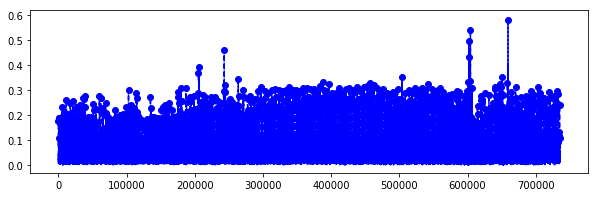

In [52]:
# Find Peaks in Error to find anomalies
data = rms_train
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 1  # desired cutoff frequency of the filter, Hz
#series = butter_lowpass_filter(data, cutoff, fs, order)
series=data
maxtab = peakdet(series,.086)
plt.figure(figsize=(10,3))
plot(series,'b--')
scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
show()

In [11]:
# Make waveform segments for clustering
# 
dataset = data.values 
train_size = int(len(dataset) * split_ratio)

train, test = dataset[0:train_size],dataset[train_size:len(dataset)]

segment_len = 500 # Length of each time segment 
slide_len = 100  # sliding window size

segments = []
for start_pos in range(0, len(train), slide_len):
    end_pos = start_pos + segment_len
    # make a copy so changes to 'segments' doesn't modify the original ekg_data
    segment = np.copy(train[start_pos:end_pos])
    # if we're at the end and we've got a truncated segment, drop it
    if len(segment) != segment_len:
        continue
    segments.append(segment)

print("Produced %d waveform segments" % len(segments))

window_rads = np.linspace(0, np.pi, segment_len)
window = np.sin(window_rads)**2
windowed_segments = []
for segment in segments:
    windowed_segment = np.copy(segment) * window
    windowed_segments.append(windowed_segment)

Produced 7350 waveform segments


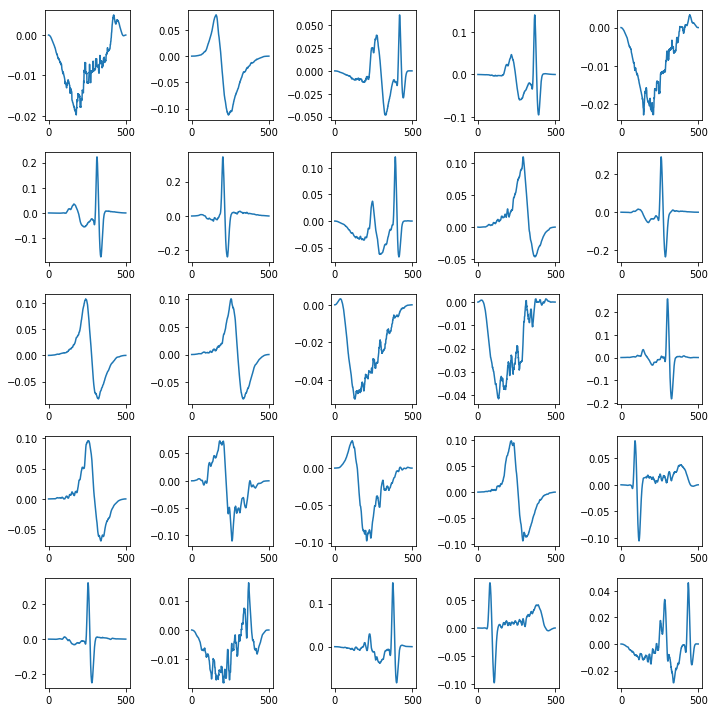

In [58]:
#plot the waveform segments
plot_waves(windowed_segments, step=100)

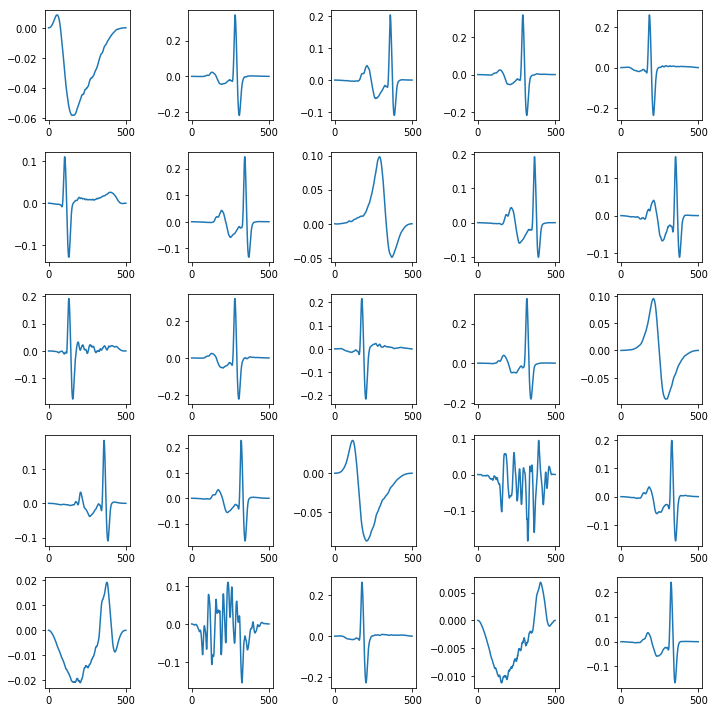

In [60]:
# K-mean clustering on the segemented waveforms

clusterer = KMeans(n_clusters=500) # n_clusters to be adjusted based on dataset
clusterer.fit(windowed_segments)

# Plot the clusters
plot_waves(clusterer.cluster_centers_, step=10) 

In [61]:
# Prediction on Test Data
# Waveform Segementation on Test data
slide_len = int(segment_len/2)
test_segments = sliding_chunker(
    test,
    window_len=segment_len,
    slide_len=slide_len
)

# Test Data Reconstruction using clusters
reconstruction = np.zeros(len(test))
slide_len = int(segment_len/2)

for segment_n, segment in enumerate(test_segments):
    # don't modify the data in segments
    segment = np.copy(segment)
    segment *= window
    nearest_centroid_idx = clusterer.predict(segment.reshape(1,-1))[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    # overlay our reconstructed segments with an overlap of half a segment
    pos = segment_n * slide_len
    reconstruction[pos:pos+segment_len] += nearest_centroid

n_plot_samples = 100000

error = reconstruction[0:n_plot_samples] - test[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)

Maximum reconstruction error was 0.1542
98th percentile of reconstruction error was 0.0271


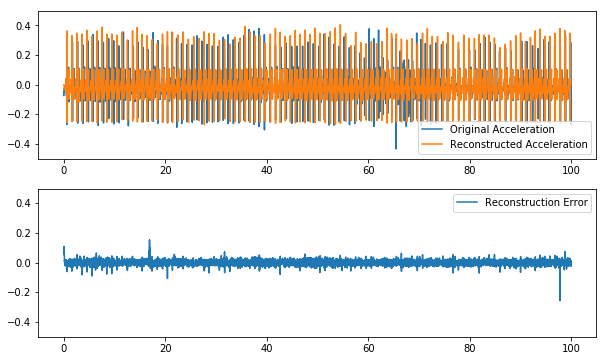

In [62]:
# Plotting the Results

print("Maximum reconstruction error was %.4f" % error.max())
print("98th percentile of reconstruction error was %.4f" % error_98th_percentile)
time=np.arange(1,n_plot_samples+1)/1000
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(time,data[0:n_plot_samples], label="Original Acceleration")
plt.plot(time,reconstruction[0:n_plot_samples], label="Reconstructed Acceleration")
plt.legend()
plt.ylim((-0.5,0.5))
plt.subplot(2,1,2)
plt.plot(time,error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.ylim((-0.5,0.5))
plt.show()